# UCLAIS Tutorial Series Challenge 2

We are proud to present you with our second challenge of the 2022-23 UCLAIS tutorial series: CIFAR10 image classification problem. You will be introduced to a variety of core concepts in Computer Vision and specifically the implementation of Convolutional Neural Network architecture using `TensorFlow`. 

This Jupyter notebook will guide you through the various general stages involved in end-to-end machine learning projects, including data visualisation, data preprocessing, model selection, model training and model evaluation. Finally, you will get the chance to submit your results to [DOXA](https://doxaai.com/).

If you do not already have a DOXA account, you will want to [sign up](https://doxaai.com/sign-up) first before proceeding.


## Background & Motivation

**CIFAR 10**

![title](./media/CIFAR-10.png)

**Background**: Image classification is one of the fundamental tasks in the domain of Computer Vision. It has revolutionized and propelled technological advancements in the most prominent fields, including the automobile industry, healthcare, manufacturing, and more. Hence, for this challenge, our problem would be to predict (or classify) the class of the given image, which comes from the well-known CIFAR-10 dataset. The images in the dataset belongs to 10 different classes.

**Objective**: Our objective is to be able to predict the class that each image belong to.

**Dataset**: The dataset is based on the following [CIFAR-10 dataset](hhttps://www.cs.toronto.edu/~kriz/cifar.html). We have divided the dataset into **'small dataset'** and **'large dataset'**. The small dataset contains 15,000 images, where each class has 1,500 images. Whereas for the large dataset, it contains 50,000 images in total, where each classs has 5,000 images. The partitioned dataset can be accessed via this [Google Drive](https://drive.google.com/drive/folders/11M8y08hEDTmMpVq3tZCU9ajX7Gui_0nN).

## Installing and Importing Useful Packages

To get started, we will install a number of common machine learning packages.

In [ ]:
%pip install numpy pandas matplotlib seaborn scikit-learn doxa-cli gdown

In [5]:
# Import relevant libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

# Import relevant sklearn classes/functions related to data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Import relevant TensorFlow classes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
      
%matplotlib inline

## Data Loading
The first step is to gather the data that we will be using. The data can be downloaded directly via [Google Drive](https://drive.google.com/drive/folders/11M8y08hEDTmMpVq3tZCU9ajX7Gui_0nN) or just by simply running the cell below. 

In [ ]:
# Let's download the dataset if we don't already have it!
if not os.path.exists("data"):
    os.makedirs("data", exist_ok=True)

    !gdown https://drive.google.com/drive/folders/11M8y08hEDTmMpVq3tZCU9ajX7Gui_0nN -O ./data --folder

We will be using the small dataset for this tutorial. Feel free to change to the large dataset if you want as it can always improve your model, but at the expense of computing power.

In [7]:
# Load the saved .npz file
data_original = np.load('./data/train_small.npz')['data']

# We then make a copy of the dataset that we can manipulate
# and process while leaving the original intact
data = data_original.copy()

In [8]:
# Load the saved label
label = np.genfromtxt("./data/train_small_label.csv").astype('uint8')

## Data Understanding & Visualisation
Before we start to train our Machine Learning model, it is important to have a look and understand first the dataset that we will be using. This will provide some insights onto which model, model hyperparameter, and loss function are suitable for the problem we are dealing with. 

In [9]:
# Let's have a look at the shape of our training and testing set
print(f"Shape of the dataset: {data.shape}")
print(f"Shape of the label: {label.shape}")

Shape of the dataset: (15000, 32, 32, 3)
Shape of the label: (15000,)


In [10]:
# Print the output
print(label)

[9 2 5 ... 7 4 4]


In [11]:
# Print the label name
label_name = open("./data/label.txt").read().splitlines()
print(label_name)


['cat', 'dog', 'truck', 'bird', 'airplane', 'ship', 'frog', 'horse', 'deer', 'automobile']


Next, let's have a look on a subset of the images we have

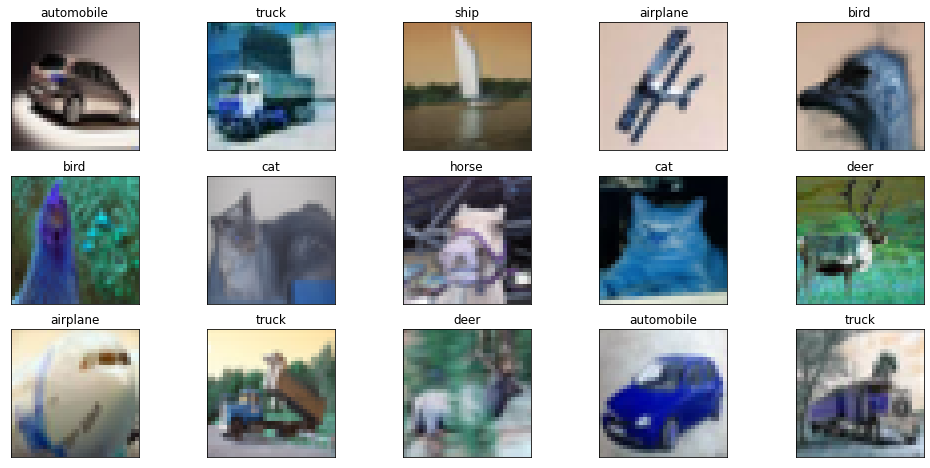

In [12]:
fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(17, 8))
index = 0
for i in range(3):
    for j in range(5):
        axes[i,j].set_title(label_name[label[index]])
        axes[i,j].imshow(data[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

From the simple code we have executed above, there are several things we can observe:

- Our dataset is composed of 15000 images
- The size of each image is 32x32 and composed of three channels (Red, Green, and Blue)
- The output is an integer in the range of 0 to 9, each corresponding to a class
- We are dealing with multi-class classification problem, where we need to predict 1 out out 10 different classes

## Label Preprocessing

As shown in the previous section, our label is composed of an integer in the range of 0 to 9. This is not really suitable for our neural network and can be improved by using one hot encoding. For this, we will be using **LabelBinarizer** class provided by Scikit-learn to encode the label

In [13]:
label_encoder = LabelBinarizer()
label_encoder.fit(label.reshape(-1,1))

LabelBinarizer()

In [14]:
encoded_label = label_encoder.transform(label.reshape(-1,1))
print(encoded_label)

[[0 0 0 ... 0 0 1]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Neat! Now, our label is in one hot encoding format. 

## Splitting the Training and Validation Set

The next preprocessing step that need to be done before we can proceed to the training step is to split our dataset into the training set and validation set. The training set will be used for the training of our model while the validation set will be used to compare the performance of different Machine Learning (or Neural Network) models.


In [15]:
# Split our features and output into a training set and a validation set
X_train, X_valid, y_train, y_valid = train_test_split(data, encoded_label, test_size=0.2)

# In this case, the test_size parameter is equal to 0.2, so our test set (or rather the validation set) will 
# have 20% the data, while the training set will have the other 80% of the data

## Constructing CNN

Now that we have done all of the required preprocessing steps, we can proceed to the most exciting stage, which is constructing the neural network. For this, we will build a Convolutional Neural Network which is a neural network architecture that is well known within the Computer Vision domain. 

In [16]:
# Print the shape of the training set
print(f"Shape of training set: {X_train.shape}")

# Set a variable to store the shape of the image as it will be used at a later stage
input_shape = X_train[0].shape
print(f"Shape of the input image: {input_shape}")

Shape of training set: (12000, 32, 32, 3)
Shape of the input image: (32, 32, 3)


To construct the Neural Network, we will be using the functionality provided by TensorFlow which greatly simplifies the task of building a neural network. This [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers) provides all the building block we can use to construct a Neural Network model.

In [17]:
model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(rate=0.5),
    Dense(units=64, activation='relu'),
    Dense(units=10, activation='softmax'),
])

That's it! With a very few few lines of code, we are able to create a Convolutional Neural Network. There are only two important rules that you need to follow:

- The first NN block must has the 'input_shape' argument that contains the size of the input images
- The final NN block must satisfy with the output we are predicting

Other than that, you can be creative on how you want to engineer your Neural Network architecture. Visit [TensorFlow Keras Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) for further information on what other NN building blocks that you can implement.

In [18]:
# Let's have a look at the summary of the model we've created
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 128)               2097280   
                                                        

There is a total parameter of ~2,000,000 for this architecture. Hence, around ~2,000,000 neurons are being trained for this problem. As you can imagine, the larger and more complex your architecture is, the higher the number of parameters that need to be trained hence, it will require a large computation power.

Shown below is the illustration of the CNN architecture we just created.
Go to this [cool website](http://alexlenail.me/NN-SVG/index.html) where you can visualize the neural network by inputting the parameters of your neural network
![CNN Architecture](./media/CNNArchitecture.png)

## Training the Model

This is where the magic happens. We will start training our training set with the neural network architecture that we have created before.



In [19]:
# Set all the required hyperparameters before starting the training process
model.compile(optimizer=Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

# Start the training and save its progress in a variable called 'history'
history = model.fit(x=X_train, y=y_train, validation_data = (X_valid, y_valid), epochs=10)

Epoch 1/10
375/375 [==============================] - 8s 19ms/step - loss: 2.6073 - accuracy: 0.2107 - val_loss: 1.9048 - val_accuracy: 0.2913
Epoch 2/10
375/375 [==============================] - 7s 18ms/step - loss: 1.8415 - accuracy: 0.2948 - val_loss: 1.6600 - val_accuracy: 0.3963
Epoch 3/10
375/375 [==============================] - 7s 19ms/step - loss: 1.7180 - accuracy: 0.3418 - val_loss: 1.6530 - val_accuracy: 0.4127
Epoch 4/10
375/375 [==============================] - 8s 21ms/step - loss: 1.6055 - accuracy: 0.3819 - val_loss: 1.5403 - val_accuracy: 0.4627
Epoch 5/10
375/375 [==============================] - 7s 18ms/step - loss: 1.4986 - accuracy: 0.4307 - val_loss: 1.5347 - val_accuracy: 0.4503
Epoch 6/10
375/375 [==============================] - 7s 18ms/step - loss: 1.3977 - accuracy: 0.4657 - val_loss: 1.4007 - val_accuracy: 0.5023
Epoch 7/10
375/375 [==============================] - 7s 18ms/step - loss: 1.3159 - accuracy: 0.5011 - val_loss: 1.4315 - val_accuracy: 0.4943

You may realize that it take a bit of a time to train the model (especially if you are training on CPU) since we are training approximately ~2,000,000 parameters. If you do not have any access to a powerful compute, you can use the free GPU provided by Google Colab by changing its runtime type. 

**How to change the Runtime Type on Colab?**
1. Go to the Toolbar located at the top, and click 'Runtime'
2. Click the 'Change runtime type' section
3. A window will pop up and you can select either to use GPU, or TPU as your hardware accelerator

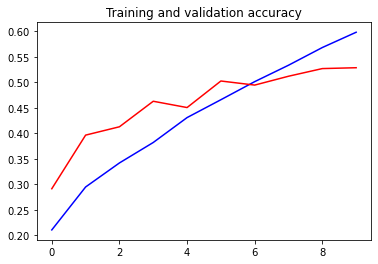

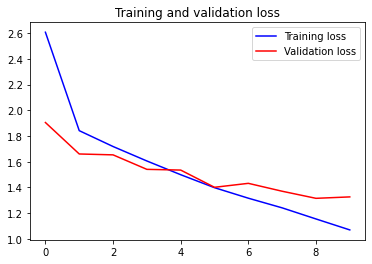

In [20]:
# Now that we have trained our model, let's plot how our model performed 
# on both the training and validation dataset as the number of iteration increases
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.figure(1)
plt.plot(epochs, accuracy, 'b', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend
plt.show()

plt.figure(2)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

From the observation above, our Neural Network architecture seems to have done a good job since the validation loss keeps getting smaller and smaller in tandem with the training loss.

## Analyse the Model

Let's proceed to analyse our model further. The hope is so that we might be able to capture some insight that can be used to create a better CNN architecture.

In [21]:
# Let's do the prediction on validation set and set the 'neuron' that has the largest value as our prediction
# (remember that we have 10 neurons at the end of our CNN architecture)
prediction = model.predict(X_valid)
y_pred = np.argmax(prediction, axis=1)

# Do the same thing for our true label
y_true = np.argmax(y_valid, axis=1)

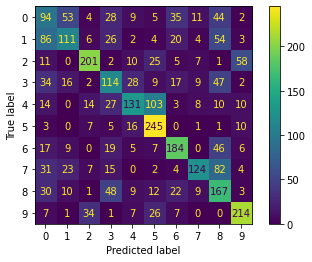

In [22]:
print(ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred))

## Preparing our DOXA Submission

Once we are confident with the performance of our model, we can start deploy our model onto DOXA! 

In [23]:
# Create a submission folder by downloading it 'curling' it from Github
if not os.path.exists("submission"):
  os.makedirs("submission")
  !curl https://raw.githubusercontent.com/UCLAIS/doxa-challenges/main/Challenge-2/submission/doxa.yaml --output submission/doxa.yaml
  !curl https://raw.githubusercontent.com/UCLAIS/doxa-challenges/main/Challenge-2/submission/run.py --output submission/run.py

In [24]:
# Save the CNN model in the submission folder
model.save("submission/model")          

INFO:tensorflow:Assets written to: submission/model/assets


## Submitting to DOXA

Before you can submit to DOXA, you must first ensure that you are enrolled for the challenge on the DOXA website. Visit [the challenge page](https://doxaai.com/competition/uclais-2) and click "Enrol" in the top-right corner.

You can then log in using the DOXA CLI by running the following command:

In [ ]:
!doxa login

You can then submit your results to DOXA by running the following command:

In [ ]:
!doxa upload submission

Yay! You have (probably) just uploaded your model to DOXA! Let's give DOXA some time for it to evaluate the performance of your model. You will then be able to see how your model performs on the [scoreboard](https://doxaai.com/competition/uclais-2)!

## Possible Improvements

The performance of our model on the validation set is approximately 55%. So, there is definitely scope for improvement! Here are a some ways we could improve the process: 

**1. Image Preprocessing**
- Maybe we can standardize, or do some thresholding, or even changing the color space of our dataset as an additional image preprocessing step.
- However, it can be a little bit tricky since every image in our dataset is very different from one another. Our dataset does not have a similar nature as medical imaging dataset where every image looks sort of similar from each other which we can take advantage of.

**2. Better Architecture**
- The architecture that we have built is a very simple architecture. We can definitely improve our model by building a deeper architecture (hence why some NN are called Deep Neural Network 😎). Try have a look at this famous [VGG-16](https://www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide/notebook) and [LeNet-5](https://www.kaggle.com/code/blurredmachine/lenet-architecture-a-complete-guide/notebook) architecture, and try build sort of a similar architecture as what they have done.

**3. Large Training Set**
- In this solution, we are only dealing with the small dataset. Changing to a large dataset can definitely improve the performance of our model
- On top of that, we can add more training set by performing data augmentation. Refer to this [website](https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/) for further information on this topic.

And perhaps, many more...